# Introduction

The timeseries created by the meter does not have any entries for times between power out and power on events.  
This notebook adds zeros to the timestamp samples that fall within these gaps.

There are two possibilities for a lack of timestamp data that we handle:

- there is a reported and recorded power gap in the messages
- there has been a transmission or recording error

In the first case with a recorded power gap, we want to be sure that valid entries of zero power consumption are inserted into the timeseries record.
In the second case, we have no knowledge, and these should remain as null values.

In this notebook, I will develop a prototype algorithm to insert these zeros.

# Method

- resample datetime index for timeseries on one-minute intervals (without replacement)
- use or modify the boolean message routine to create zeros for insertion
- insert these zeros into the time series


# Results

These results look correct on the test data.

# Next Work

- add this function to the library
- apply this function to the village data sets
- create tests for this function

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa

def wpa_insert_power_gap_zeros(energy_data, messages):
    # this puts zeros in the recorded power gaps and leaves data gaps untouched
    power_down = messages[messages['message']=='Power Down'].index.values
    power_up = messages[messages['message']=='Power Up'].index.values
    diffed = energy_data.resample('1T').asfreq().diff().shift(-1)
    for i in diffed.index.values:
        # if either boundary of the interval is in a power gap, we want to insert a zero
        # if the insertion point of the index is one greater for the power_down time, you are in a gap
        if np.searchsorted(power_down, i) == np.searchsorted(power_up, i) + 1:
            diffed.loc[i]['kWh export'] = 0
        end_interval = i + np.timedelta64(1,'m')
        if np.searchsorted(power_down, end_interval) == np.searchsorted(power_up, end_interval) + 1:
            diffed.loc[i]['kWh export'] = 0
    return diffed['kWh export']

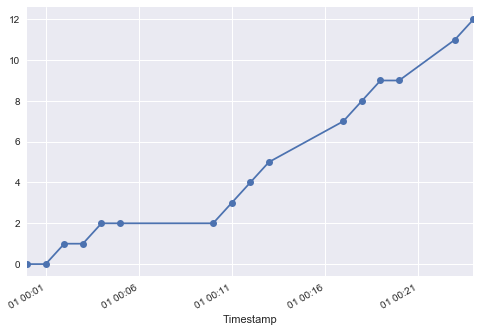

In [3]:
# here is the raw data plotted
vname = 'test'
energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
messages = wpa.load_message_file(vname + '-messages.csv')
energy_data['kWh export'].plot(marker='o')

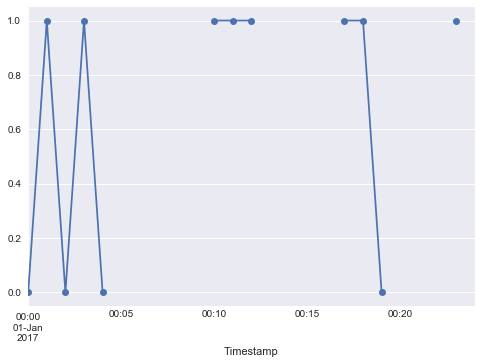

In [4]:
# here is a discrete difference with nulls for points with missing left neighbors
# the sample represents the one minute interval following the timestamp
diffed = energy_data.resample('1T').asfreq().diff().shift(-1)
diffed['kWh export'].plot(marker='o')

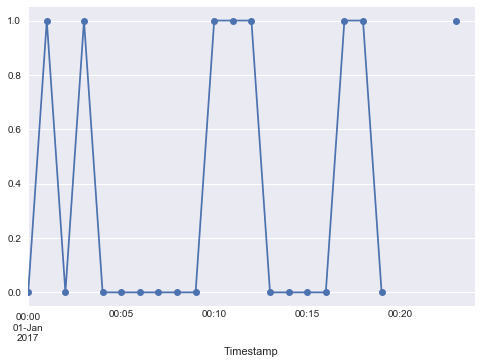

In [5]:
# here is the diffed data using the insertion function
wpa_insert_power_gap_zeros(energy_data, messages).plot(marker='o')